```
Copyright (c) Gradient Institute. All rights reserved.
Licensed under the Apache 2.0 License.
```

This notebook demonstrates the effect of feature dimensionality and collinearity on linear models for causal inference.

Hahn, P.R., Carvalho, C.M., Puelz, D., He, J., 2018. Regularization and Confounding in Linear Regression for Treatment Effect Estimation. Bayesian Anal. 13. https://doi.org/10.1214/16-BA1044


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import mean_squared_error

from twostageridge import TwoStageRidge, make_combined_stage_scorer, ridge_weights

# Generate the data

In [2]:
np.random.seed(666)

# Random projection settings
min_proj = 50  # Minimum projection dimensionality
max_proj = 300  # Maximum projection dimensionality
dim_steps = 8  # Number of steps between min and max dimensions
rbf_gamma = 1.  # inverse length scale of random projection (Random RBF)


# Data generation
N = 500  # samples
normalise_weights = True  # normalise the weights for the controls as a function of dimension
                          # this keeps the magnitude of Z and Y the same regardless of dimension
                          # of X.


# Latent low dimensional confounders - X
D = 5
mu_x = np.zeros(D)
A = np.random.randn(D, D)
cov_x = A @ A.T / D


# Treatment - Z
sig_eps = 0.4


# Target - Y
alpha = 0.2
sig_nu = 0.7


# Number of random dataset draws to create error bars
S = 10

# Number of folds to use for CV regularisation coefficient selection
CV = 5


# Real generative weights
gamma_max = np.random.randn(max_proj)
beta_max = np.random.randn(max_proj)


# Generation function
def generate_data(proj_D):
    
    gamma = np.copy(gamma_max[:proj_D])
    beta = np.copy(beta_max[:proj_D])
    if normalise_weights:
        gamma /= np.sqrt(proj_D)
        beta /= np.sqrt(proj_D)
    
    # Generate the latent covariates, and then a smooth non-linear function of these
    Xo = np.random.multivariate_normal(mean=mu_x, cov=cov_x, size=N)
    X = RBFSampler(n_components=proj_D, gamma=rbf_gamma).fit_transform(Xo)

    # Generate data according to the causal relationships X->Z, X->Y, Z->Y
    Z = X @ gamma + sig_eps * np.random.randn(N)
    Y = alpha * Z + X @ beta + sig_nu * np.random.randn(N)

    W = np.hstack((Z[:, np.newaxis], X))
    
    return W, Y

# Effective rank and collinearity

Plot the effective rank of the projections, and the condition number of the matrix $\mathbf{W}^\top \mathbf{W}$ as an indication of how unstable the OLS result will be.

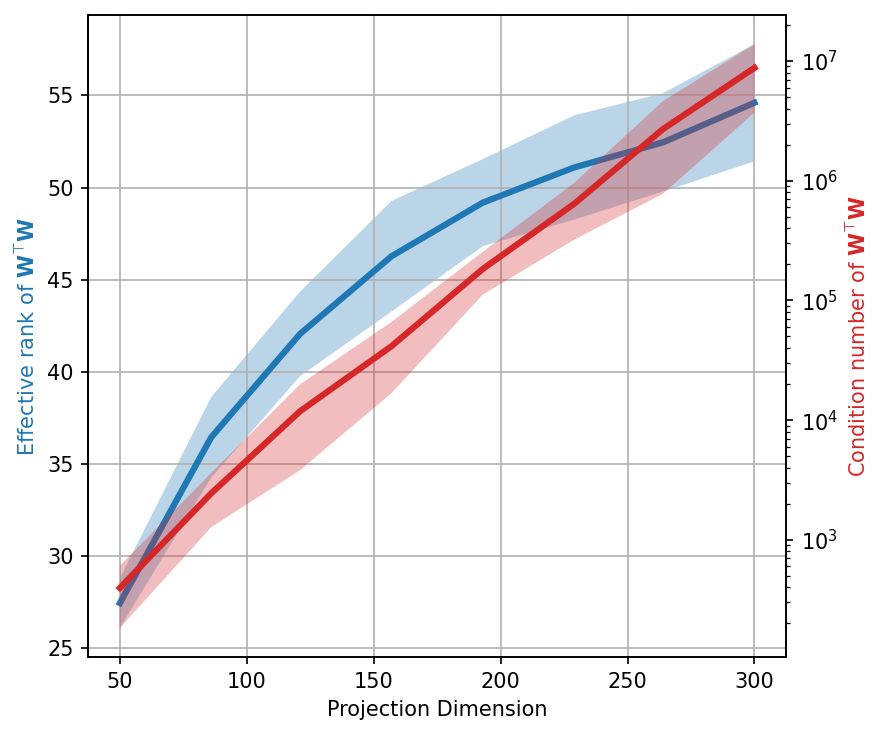

In [3]:
projected_dims = np.linspace(min_proj, max_proj, dim_steps).round().astype(int)

samples = 50

# Effective rank
erank = np.zeros((samples, dim_steps))
condn = np.zeros((samples, dim_steps))
for i, d in enumerate(projected_dims):
    for j in range(samples):
        W, _ = generate_data(d)
        _, s, _ = np.linalg.svd(W.T @ W)
        norm_s = np.abs(s).sum()
        p = s / norm_s
        condn[j, i] = np.max(s) / np.min(s)
        erank[j, i] = np.exp(-(p * np.log(p)).sum())
        
erank_mean = erank.mean(axis=0)
erank_std = erank.std(axis=0)
fig, ax1 = plt.subplots(figsize=(6, 5), dpi=150)
color = 'tab:blue'
ax1.plot(projected_dims, erank_mean, linewidth=3.)
ax1.fill_between(projected_dims, erank_mean - erank_std, erank_mean + erank_std,
                 alpha=0.3, edgecolor="none")
ax1.grid()
ax1.axis("tight")
ax1.set_xlabel("Projection Dimension")
ax1.set_ylabel("Effective rank of $\mathbf{W}^\\top \mathbf{W}$", color=color)

condn_mean = condn.mean(axis=0)
condn_std = condn.std(axis=0)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(projected_dims, condn_mean, linewidth=3., color=color)
ax2.fill_between(projected_dims, condn_mean - condn_std, condn_mean + condn_std,
                 alpha=0.3, color=color, edgecolor="none")
ax2.set_yscale("log")
ax2.axis("tight")
ax2.set_ylabel("Condition number of $\mathbf{W}^\\top \mathbf{W}$", color=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Generate bias comparison results

In [4]:
# Regularisation coefficients to search over
ridge_coefs = np.geomspace(1e-2, 1e2, 10)

# Two stage with grid-search
ts = GridSearchCV(
    TwoStageRidge(treatment_index=0),
    param_grid={"regulariser1": ridge_coefs, "regulariser2": ridge_coefs},
    cv=CV
)

# Models to compare
models = {
    "ols": LinearRegression(),
    "lasso": LassoCV(n_alphas=20, max_iter=20000, cv=CV),
    "ridge": RidgeCV(alphas=ridge_coefs),
    "2-stage": ts
}

In [ ]:
# pre-allocate result arrays
n_D = len(projected_dims)
results_dict = {"dimensionality": projected_dims}
results_dict.update({k + "_err": np.zeros(n_D) for k in models.keys()})
results_dict.update({k + "_err_std": np.zeros(n_D) for k in models.keys()})
results_dict.update({k + "_bias": np.zeros(n_D) for k in models.keys()})
results_dict.update({k + "_bias_std": np.zeros(n_D) for k in models.keys()})
results = pd.DataFrame(results_dict).set_index("dimensionality")


# Run experiment
for proj_D in projected_dims:
    
    err = {k: np.zeros(S) for k in models.keys()}
    bias = {k: np.zeros(S) for k in models.keys()}
    
    # Sample random datasets
    for s in range(S):

        # Generate the data and split into train and test
        W, Y = generate_data(proj_D)
        W_train, W_test, Y_train, Y_test = train_test_split(W, Y, train_size=0.9)
        
        for name, model in models.items():

            # Fit the model and get the ATE (alpha)
            model.fit(W_train, Y_train)
            if name in ["2-stage", "ridge-naive"]:
                alpha_hat = model.best_estimator_.alpha_
            else:
                alpha_hat = model.coef_[0]
            bias[name][s] = (alpha - alpha_hat)**2

            # Score on held-out data
            err[name][s] = mean_squared_error(Y_test, model.predict(W_test))

        print('.', end='')
        
    for name in models.keys():
        results.loc[proj_D, name + "_err"] = err[name].mean()
        results.loc[proj_D, name + "_err_std"] = err[name].std()
        results.loc[proj_D, name + "_bias"] = bias[name].mean()
        results.loc[proj_D, name + "_bias_std"] = bias[name].std()
        
    print()
    
results

# Plot

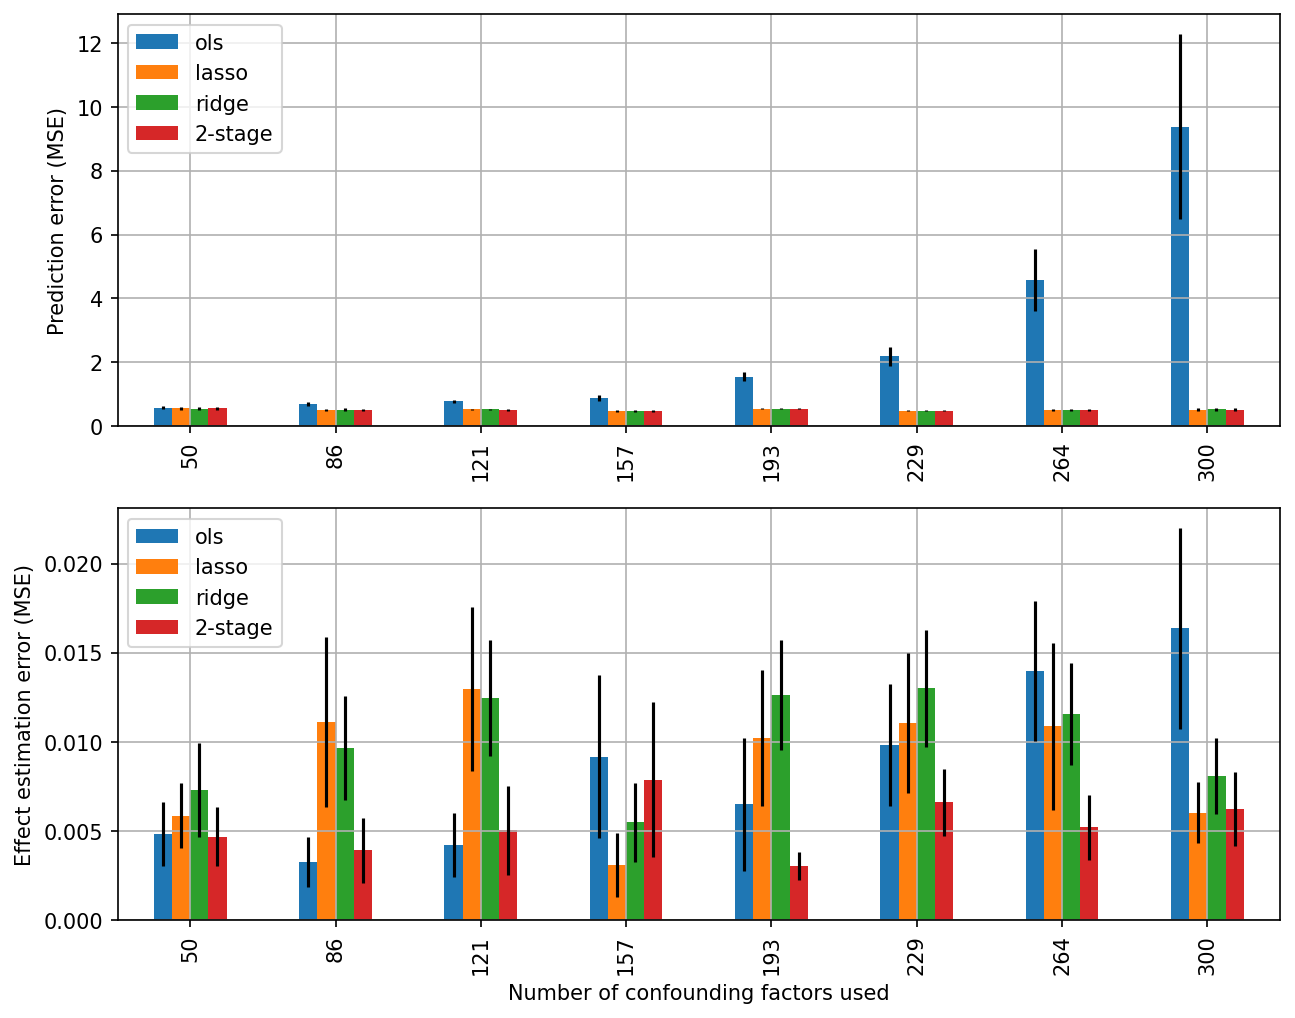

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), dpi=150)
    
pred_errors = [name + "_err" for name in models.keys()]
model_errstd = results[[name + "_err_std" for name in models.keys()]] / np.sqrt(S)
model_errstd.columns = pred_errors
results[pred_errors].plot(kind='bar', yerr=model_errstd, ax=ax1)
    
ax1.set_ylabel("Prediction error (MSE)")
ax1.grid()
ax1.legend(models.keys())
ax1.set_xlabel("")

model_biases = [name + "_bias" for name in models.keys()]
model_bstds = results[[name + "_bias_std" for name in models.keys()]] / np.sqrt(S)
model_bstds.columns = model_biases
results[model_biases].plot(kind='bar', yerr=model_bstds, ax=ax2)
    
ax2.set_ylabel("Effect estimation error (MSE)")
ax2.grid()
ax2.legend(models.keys())
ax2.set_xlabel("Number of confounding factors used")
plt.show()